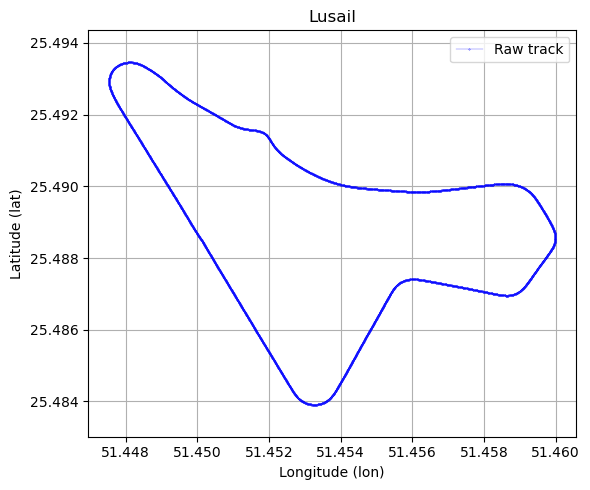

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Read raw track from the cleaned file
df = pd.read_csv("D:\Batavia\SEM 2026\Data & Telemetry\lusail_track_coordinates1.csv")

lat_raw = df["lat"].values
lon_raw = df["lon"].values

plt.figure(figsize=(6, 5))

# Blue dots connected by thin line, like Fig. 5.5
plt.plot(lon_raw, lat_raw, "b.-", markersize=0.5, linewidth=0.2, label="Raw track")

plt.xlabel("Longitude (lon)")
plt.ylabel("Latitude (lat)")
plt.title("Lusail")
plt.grid(True)
plt.axis("equal")
plt.legend()

plt.tight_layout()

plt.savefig(
    "lusail.png",   # output filename
    dpi=600,              # high resolution
    bbox_inches="tight",  # trim extra white space
    pad_inches=0.05       # small padding
)

plt.show()

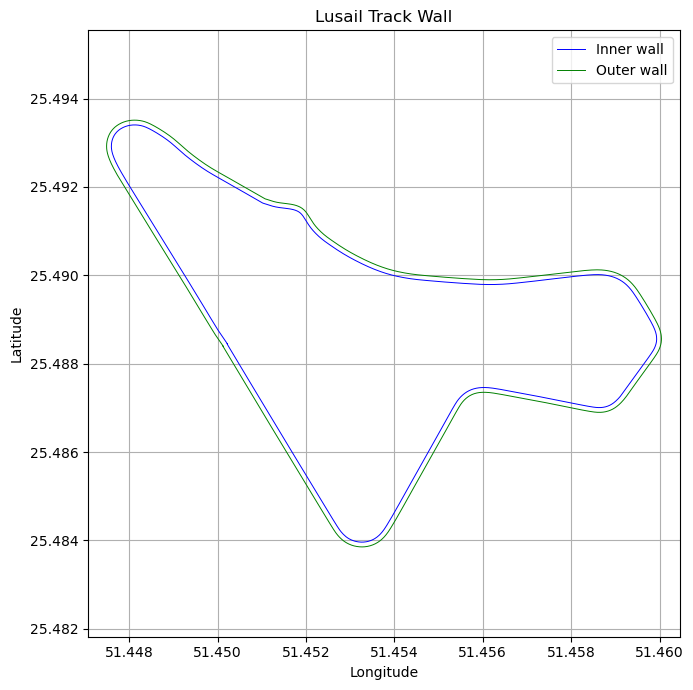

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load smoothed centerline
df = pd.read_csv("D:\Batavia\SEM 2026\Data & Telemetry\lusail_track_coordinates1.csv")   # lat_smooth, lon_smooth
lat_s = df["lat"].values
lon_s = df["lon"].values

# 2) Compute walls from centerline
track_width = 12 # meters
meters_per_deg = 111_000.0 # approx m per degree

dx = np.diff(lon_s)
dy = np.diff(lat_s)
L  = np.sqrt(dx**2 + dy**2)

ux = dx / L
uy = dy / L
nx = -uy
ny = ux

lon_c = (lon_s[:-1] + lon_s[1:]) / 2
lat_c = (lat_s[:-1] + lat_s[1:]) / 2

offset_deg = (track_width / 2) / meters_per_deg

lon_inner = lon_c - nx * offset_deg
lat_inner = lat_c - ny * offset_deg
lon_outer = lon_c + nx * offset_deg
lat_outer = lat_c + ny * offset_deg

# 3) Save walls CSV 
track_wall = pd.DataFrame({
    "seg_index":  np.arange(len(lat_c)),
    "lat_center": lat_c,
    "lon_center": lon_c,
    "lat_inner":  lat_inner,
    "lon_inner":  lon_inner,
    "lat_outer":  lat_outer,
    "lon_outer":  lon_outer,
})
track_wall.to_csv("lusail_track_wall.csv", index=False)

# 4) CLOSE THE LOOP
lon_inner_closed = np.r_[lon_inner, lon_inner[0]]
lat_inner_closed = np.r_[lat_inner, lat_inner[0]]
lon_outer_closed = np.r_[lon_outer, lon_outer[0]]
lat_outer_closed = np.r_[lat_outer, lat_outer[0]]

# 5) Plot closed walls save HD PNG
plt.figure(figsize=(7, 7))
plt.plot(lon_inner_closed, lat_inner_closed, "b-", linewidth=0.7, label="Inner wall")
plt.plot(lon_outer_closed, lat_outer_closed, "g-", linewidth=0.7, label="Outer wall")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Lusail Track Wall")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.savefig("lusail_track_wall.png", dpi=600, bbox_inches="tight", pad_inches=0.05)
plt.show()

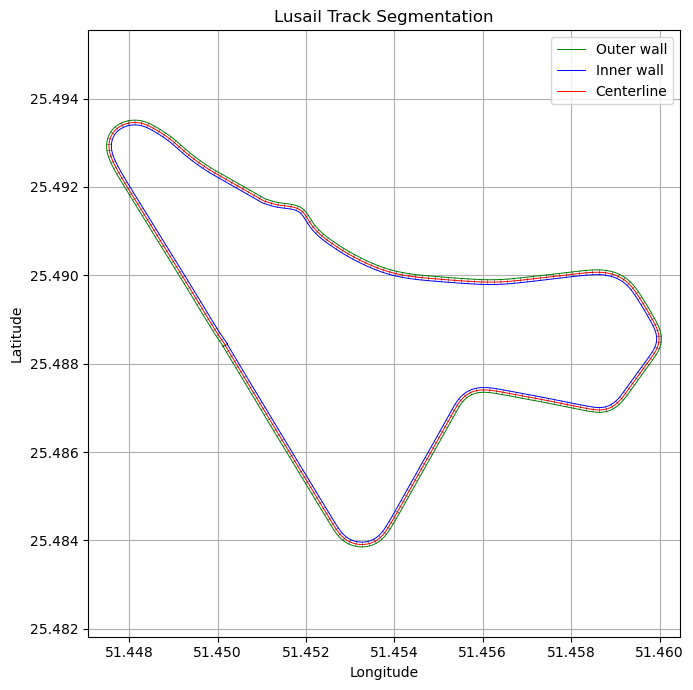

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load walls + centerline
wall = pd.read_csv("lusail_track_wall.csv")
lat_inner   = wall["lat_inner"].values
lon_inner   = wall["lon_inner"].values
lat_outer   = wall["lat_outer"].values
lon_outer   = wall["lon_outer"].values
lat_center  = wall["lat_center"].values
lon_center  = wall["lon_center"].values

# 2) Close loop for walls
lon_inner_closed = np.r_[lon_inner, lon_inner[0]]
lat_inner_closed = np.r_[lat_inner, lat_inner[0]]
lon_outer_closed = np.r_[lon_outer, lon_outer[0]]
lat_outer_closed = np.r_[lat_outer, lat_outer[0]]

plt.figure(figsize=(7, 7))

# walls & centerline
plt.plot(lon_outer_closed, lat_outer_closed, color="green", linewidth=0.7, label="Outer wall")
plt.plot(lon_inner_closed, lat_inner_closed, color="blue",  linewidth=0.7, label="Inner wall")
plt.plot(lon_center, lat_center, color="red", linewidth=0.7, label="Centerline")

# 3) segmentation lines
step = 15
line_width = 0.3

for k in range(0, len(lat_inner), step):
    plt.plot(
        [lon_inner[k], lon_outer[k]],
        [lat_inner[k], lat_outer[k]],
        color="black",
        linewidth=line_width,
        alpha=0.9,
    )

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Lusail Track Segmentation")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.savefig("lusail_track_segmentation.png",
            dpi=300, bbox_inches="tight", pad_inches=0.05)
plt.show()

Saved file: lusail_track_curvature.png


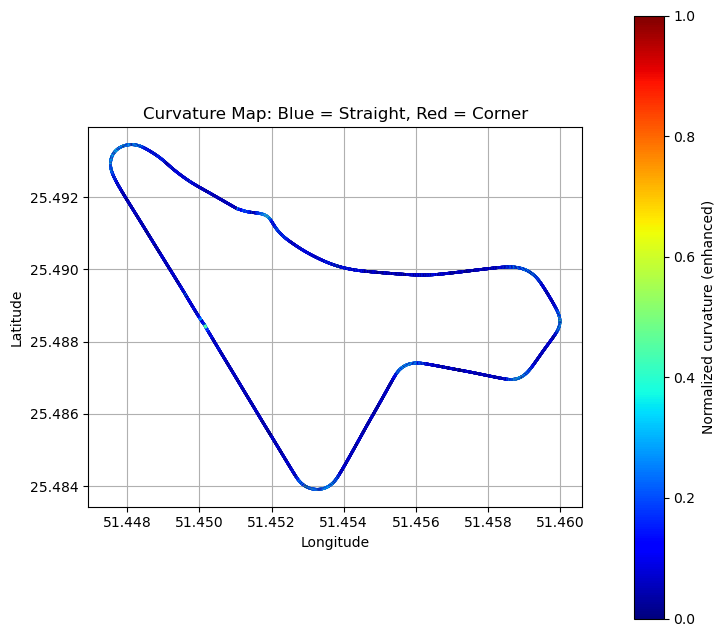

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

clean = pd.read_csv("D:\Batavia\SEM 2026\Data & Telemetry\lusail_track_coordinates1.csv")
lat = clean["lat"].values
lon = clean["lon"].values

dx = np.diff(lon)
dy = np.diff(lat)
heading = np.arctan2(dy, dx)
d_heading = np.diff(heading)
d_heading = (d_heading + np.pi) % (2 * np.pi) - np.pi

curv = np.abs(d_heading)
curv_norm = curv / curv.max()
curv_norm = curv_norm**0.5

lon_mid = (lon[1:-1] + lon[2:]) / 2
lat_mid = (lat[1:-1] + lat[2:]) / 2

fig, ax = plt.subplots(figsize=(7.5, 7))

cmap = plt.colormaps["jet"]

for i in range(len(lon_mid) - 1):
    c = cmap(curv_norm[i])
    ax.plot(
        [lon_mid[i], lon_mid[i+1]],
        [lat_mid[i], lat_mid[i+1]],
        color=c,
        linewidth=2,
    )

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Curvature Map: Blue = Straight, Red = Corner")
ax.grid(True)
ax.set_aspect("equal", adjustable="box")

sm = mpl.cm.ScalarMappable(cmap=cmap)
sm.set_array(curv_norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.9, pad=0.08)
cbar.set_label("Normalized curvature (enhanced)")

# connect last midpoint to first midpoint
c_last = cmap(curv_norm[-1])
ax.plot(
    [lon_mid[-1], lon_mid[0]],
    [lat_mid[-1], lat_mid[0]],
    color=c_last,
    linewidth=2,
)

plt.tight_layout()

# ---- SAVE PNG ----
outfile = "lusail_track_curvature.png"
plt.savefig(outfile, dpi=600, bbox_inches="tight", pad_inches=0.05)
print("Saved file:", outfile)

plt.show()